# Sentiment Analysis 
## ComputeFest 2019
**Harvard University**<br>
**Winter 2019**<br>

In [1]:
import keras
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import one_hot
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


## I. Sentiment Analysis: First Pass

This exercise is designed to help you transform and model textual data. You may find the tutorial [here](http://scikit-learn.org/stable/modules/feature_extraction.html) helpful.

Your goal is to vectorize a small set of twitter data and predict the polarity (positive or negative) -- a property of the content of tweet -- of tweets using Logistic Regression.

1. Load `tweet.csv`, this is a data set containing tweets and their polarity.

2. Using `CountVectorizer`, turn each tweet into a vector of features. Play with the values for `min_df`, `max_df` and `stop_words`.

3. Get the names of the features you produced, using `get_feature_names`.

3. Split the data set into train and test (make sure there are both types of polarity present in train)

4. Use Logistic Regression to predict the polarity of the test tweets. How good is your model? What is the effect of your choice of `min_df`, `max_df` and `stop_words` on your model?

In [2]:
df = pd.read_csv('tweet.csv', delimiter=';')
df.head()

,id,polarity,tweet
0,1467933112,0,the angel is going to miss the athlete this we...
1,2323395086,0,It looks as though Shaq is getting traded to C...
2,1467968979,0,@clarianne APRIL 9TH ISN'T COMING SOON ENOUGH
3,1990283756,0,drinking a McDonalds coffee and not understand...
4,1988884918,0,So dissapointed Taylor Swift doesnt have a Twi...


### 1. Example: Process the Corpus

In [3]:
# define documents
corpus = ['Well done!', 'Good work, good!', 'Great effort', 'nice work', 'Excellent!', 'great work', 'nice effort', 
          'Weak', 'Poor effort!', 'not good', 'poor work', 'Could have done better on this.', 'not great', 'weak effort']

# define class labels
labels = np.array([1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0])

In [4]:
# vectorize text
vectorizer = CountVectorizer(stop_words=['on', 'this'], min_df=0., max_df=1.)
X = vectorizer.fit_transform(corpus).toarray()
Y = labels

In [5]:
X[1]

array([0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 1], dtype=int64)

In [6]:
vectorizer.get_feature_names() 

['better',
 'could',
 'done',
 'effort',
 'excellent',
 'good',
 'great',
 'have',
 'nice',
 'not',
 'poor',
 'weak',
 'well',
 'work']

### Exercise: Process the tweet the same way.

### 2. Example: Train a Classifier

In [7]:
# split the data into training and testing
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=.4)

# fit a logistic regression model to classify this data
simple_model = LogisticRegression()
simple_model.fit(X_train, Y_train)
print('Train accuracy:', simple_model.score(X_train, Y_train))
print('Test accuracy:', simple_model.score(X_test, Y_test))

Train accuracy: 1.0
Test accuracy: 0.666666666667


### Exercise: Train a classifier on the tweet corpus

### 3. Analysis
0. Experiment with the `stop_words`, `min_df` and `max_df` parameters in `CountVectorizer`.
1. Do the results of your classifier make sense? (**Hint:** explore the distribution of tweets in both polarity classes)
2. What can you do to improve your model?
3. A different way to represent documents: try using the `TfidfVectorizer` from `sklearn`

## I. Sentiment Analysis: with Neural Networks

### 1. Build a Classifier

Let's fit a MLP network -- play with the number of hidden layers, and the width. Start with sigmoid activation functions for the hidden nodes and for the output. 

***Experiment with the number of layers and observe the effect of this on the quality of the classification.***  You want to think about issues like computational effeciency and generalizability of this type of modeling. You want to compare the MLP to your logistic regression model (in terms of quality of fit, efficiency and generalizability).

In [8]:
# fix a width that is suited for visualizing the output of hidden layers
input_dim = X_train.shape[1]

# create sequential multi-layer perceptron
model = Sequential()
#layer 1
model.add(Dense(10, input_dim=input_dim, activation='sigmoid')) 
#layer 3
model.add(Dense(2, activation='sigmoid'))
#binary classification, one output
model.add(Dense(1, activation='sigmoid')) 

# configure the model
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [9]:
# fit the model
model.fit(X_train, Y_train, epochs=500, verbose=0)

In [10]:
# evaluate the training and testing performance of your model 
# note: you should extract check both the loss function and your evaluation metric
score = model.evaluate(X_train, Y_train, verbose=0)
print('Train loss:', score[0])
print('Train accuracy:', score[1])

Train loss: 0.579487264156
Train accuracy: 0.75


In [11]:
score = model.evaluate(X_test, Y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.670864403248
Test accuracy: 0.666666686535


Recall that the decision boundaries (where the class probabilites are equal and thus the model is most uncertain) for most classification data sets are non-linear (the classes cannot be separated in input space by a line or a flat surface). To learn such boundaries, we typically 

1. apply a non-linear transformation to the input data (say by adding polynomial features)
2. then fit a linear decision boundary (e.g. logistic regression or SVC)

Here, the non-linearity of the functions represented by MLP's can help us combine the two tasks into one. That is, we don't need to preprocess the data to add non-linear features, since the MLP will learn the best non-linear transformations to the input in order to achieve the best classification. Thus, this gives us a very intuitive way to interpret the output of the hidden layers of an MLP in a classification task:

> ***Outputs of each hidden layer of an MLP is a non-linear transformation of the input data into a feature space. Each hidden layer should transform the input so that it is more linearly separable.***

In the following, we interpret the hidden outputs of MLP's in a classification task as mappings of our data into different feature spaces.

Now let's plot the latent representations of our data given by each hidden layer.

To do this, we need to extract the weights learned by our model up to layer $l$, then configure another MLP with only $l$ layers using these weights and then run our training data through the second MLP.

In [12]:
# get the class probabilities predicted by our MLP on the training set
Y_pred = model.predict(X)

In [13]:
# define another MLP with no hidden layer (only input and output) using 
# the weights up to the last hidden layer from the classifier we just learned
latent_model = Sequential()
latent_model.add(Dense(10, input_dim=input_dim, weights=model.layers[0].get_weights(), activation='sigmoid'))
latent_model.add(Dense(2, weights=model.layers[1].get_weights(), activation='sigmoid'))
activations = latent_model.predict(X)

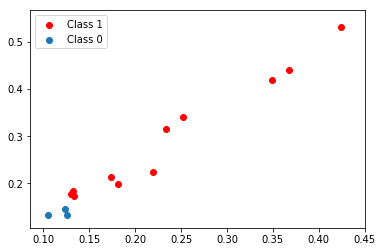

In [14]:
# plot the latent representation of our training data at the first hidden layer
Y_pred = Y_pred.reshape((Y_pred.shape[0], ))

fig, ax = plt.subplots()
ax.scatter(activations[Y_pred >= 0.5, 0], activations[Y_pred >= 0.5, 1], color='r', label='Class 1')
ax.scatter(activations[Y_pred < 0.5, 0], activations[Y_pred < 0.5, 1], label='Class 0')
ax.legend()
plt.show()

### Exercise: Build a classifier on the tweet corpus

### 2. Analysis

1. Compare the performance of your NN classifer to the Logistic Regression model. Which model does better? Why?
2. Can you improve your NN classifier?

### 3. Train a Word Embedding for Classification

In [23]:
#one hot encode the words
vocab_size = 15
encoded_corpus = [one_hot(doc, vocab_size) for doc in corpus]
print(encoded_corpus)

[[5, 2], [2, 6, 2], [9, 4], [13, 6], [3], [9, 6], [13, 4], [2], [2, 4], [3, 2], [2, 6], [3, 4, 2, 6, 13, 13], [3, 9], [2, 4]]


In [24]:
#represent each document (made into equal length) as a sequence of words
maxlen = 6
padded_corpus = pad_sequences(encoded_corpus, maxlen=maxlen, padding='post')
print(padded_corpus)

[[ 5  2  0  0  0  0]
 [ 2  6  2  0  0  0]
 [ 9  4  0  0  0  0]
 [13  6  0  0  0  0]
 [ 3  0  0  0  0  0]
 [ 9  6  0  0  0  0]
 [13  4  0  0  0  0]
 [ 2  0  0  0  0  0]
 [ 2  4  0  0  0  0]
 [ 3  2  0  0  0  0]
 [ 2  6  0  0  0  0]
 [ 3  4  2  6 13 13]
 [ 3  9  0  0  0  0]
 [ 2  4  0  0  0  0]]


In [17]:
# split the data into training and testing
X_train, X_test, Y_train, Y_test = train_test_split(padded_corpus, Y, test_size=.4)

In [18]:
# build a model to find an embedding of the words that best suits the classification task
model = Sequential()
#embedding
model.add(Embedding(input_dim=vocab_size,
                    output_dim=5, 
                    input_length=maxlen))
model.add(Flatten())

#classifier layer 1
model.add(Dense(5, activation='sigmoid'))
#classifier layer 2
model.add(Dense(2, activation='sigmoid'))
#binary classification, one output
model.add(Dense(1, activation='sigmoid')) 

In [19]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])  # Compile the model
model.fit(X_train, Y_train, epochs=500, verbose=0)  # Fit the model

In [20]:
# evaluate the training and testing performance of your model 
# note: you should extract check both the loss function and your evaluation metric
score = model.evaluate(X_train, Y_train, verbose=0)
print('Train loss:', score[0])
print('Train accuracy:', score[1])

Train loss: 0.472273349762
Train accuracy: 1.0


In [21]:
score = model.evaluate(X_test, Y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.750593483448
Test accuracy: 0.5


### Exercise: Do the same for the tweet corpus.

### 2. Analysis

1. Play with the output dimensions of the embedding layer and the architecture of the classifier.
2. Compare the performance with the other models you've built